# Environment Setup

In [1]:
# Data Formatting
import urllib.request
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from PIL import Image

# Data Viz
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Data Processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

# CNN + LSTM
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
# Download the data
for yr in range(2010, 2016):
    url = f'https://downloads.psl.noaa.gov/Datasets/cpc_us_precip/RT/precip.V1.0.{yr}.nc'
    savename = url.split('/')[-1]
    urllib.request.urlretrieve(url, savename)
    print(f"Downloaded {savename}")

In [ ]:
# Load the data
def load_data(filenames):
    datasets = []
    for filename in filenames:
        ds = xr.open_dataset(filename)
        data = ds['precip'].values  # Shape: (time, lat, lon)
        time = ds['time'].values
        datasets.append((data, ds, time))
    return datasets

# List of downloaded files
filenames = [f'precip.V1.0.{yr}.nc' for yr in range(2010, 2016)]
datasets = load_data(filenames)

# Output directory for saved plots
output_dir = "daily_precipitation_maps"
os.makedirs(output_dir, exist_ok=True)

# Data Visualization

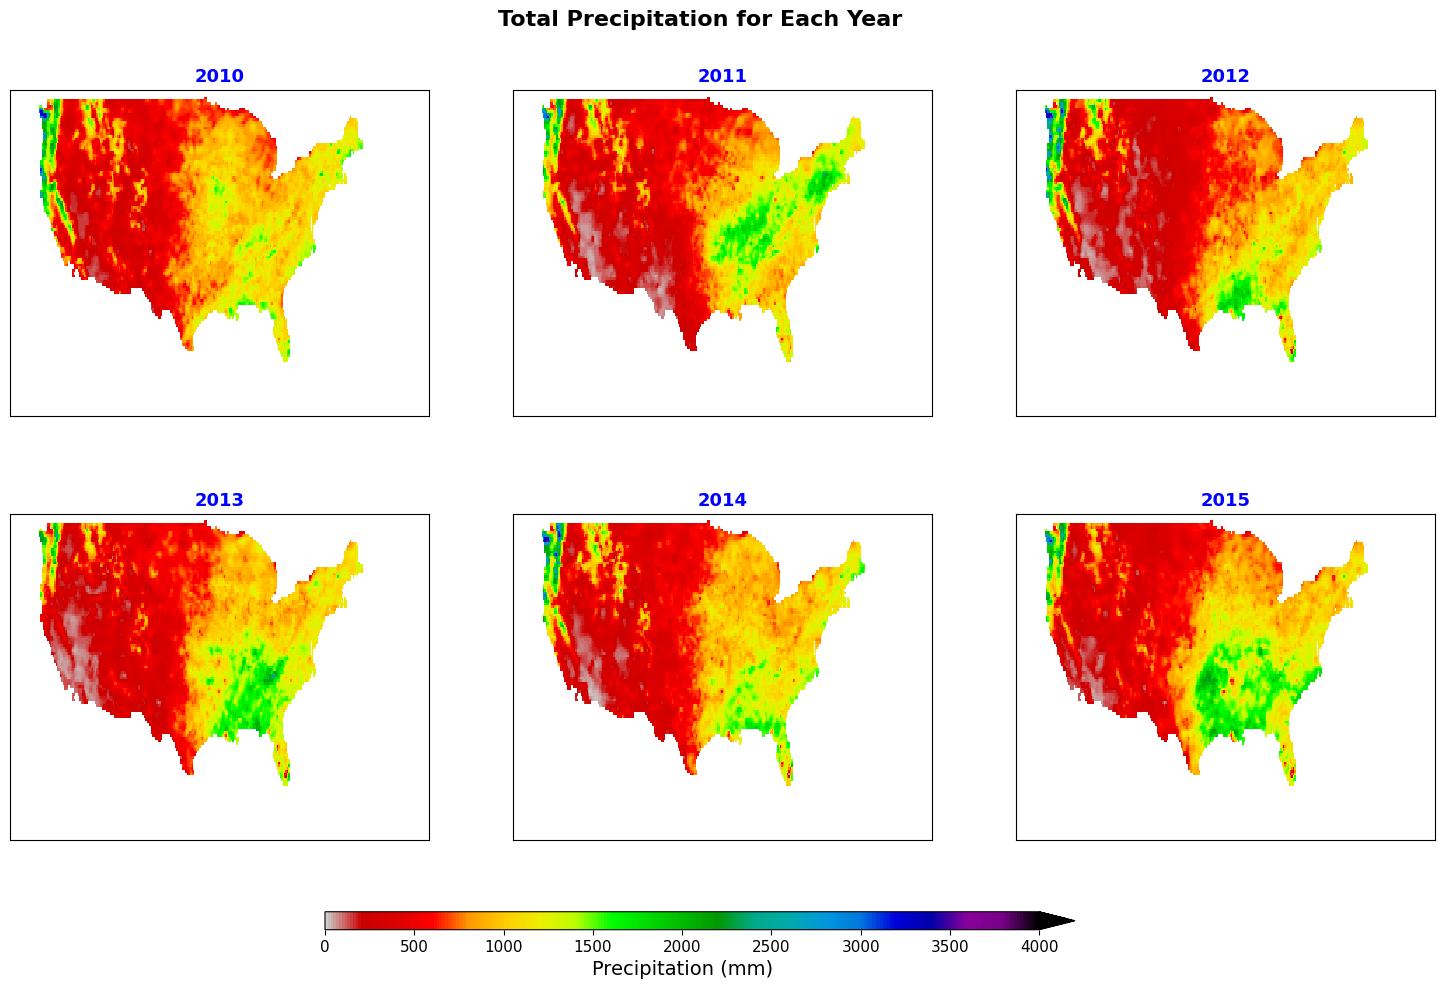

In [ ]:
# Plot average yearly data
fig = plt.figure(figsize=[15, 10], facecolor='w')
plt.subplots_adjust(bottom=0.15, top=0.90, left=0.04, right=0.99,
                    wspace=0.2, hspace=0.3)

plt.suptitle('Total Precipitation for Each Year', fontsize=16, fontweight='bold')

nrows = 2
ncols = 3
years = range(2010, 2016)

for i, (data, ds) in enumerate(datasets, start=1):
    # Calculate the sum over time for each lat/lon
    total_precip = np.sum(data, axis=0)

    # Extract latitude and longitude
    lat = ds['lat'].values
    lon = ds['lon'].values

    # Create a subplot for each year
    plt.subplot(nrows, ncols, i)
    p = plt.pcolormesh(lon, lat, total_precip,
                       vmax=4000, vmin=0, cmap='nipy_spectral_r')
    plt.xlim([lon.min(), lon.max()])
    plt.ylim([lat.min(), lat.max()])

    # Remove tick marks
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{years[i-1]}', fontsize=13,
              fontweight='bold', color='b')

# Add a colorbar at the bottom
cax = fig.add_axes([0.25, 0.06, 0.5, 0.018])
cb = plt.colorbar(p, cax=cax, orientation='horizontal', extend='max')
cb.ax.tick_params(labelsize=11)
cb.set_label(label='Precipitation (mm)', color='k', size=14)

plt.show()

# Process Data

1. Create a heatmap for each day in the data set
2. Save the heatmap with the date
3. Load the images and dates

In [6]:
# Plot daily data and save the figures
for i, (data, ds, time) in enumerate(datasets):
    # Extract latitude and longitude
    lat = ds['lat'].values
    lon = ds['lon'].values

    # Loop through each day; tqdm is just a progress bar, you can ignore it
    for day_idx in tqdm(range(data.shape[0]), desc=f"Processing {2010 + i}"):
        daily_precip = data[day_idx, :, :]
        date_str = np.datetime_as_string(time[day_idx], unit='D')

        # Create a figure for each day
        fig, ax = plt.subplots(figsize=[10, 7], facecolor='w')
        plt.title(f'Precipitation on {date_str}', fontsize=16, fontweight='bold')

        # Create the heatmap
        p = ax.pcolormesh(lon, lat, daily_precip, vmax=150, vmin=0, cmap='nipy_spectral_r')
        plt.xlim([lon.min(), lon.max()])
        plt.ylim([lat.min(), lat.max()])

        # Add colorbar
        cb = plt.colorbar(p, ax=ax, orientation='vertical', extend='max')
        cb.ax.tick_params(labelsize=11)
        cb.set_label(label='Precipitation (mm)', color='k', size=14)

        # Save the figure
        filename = os.path.join(output_dir, f'precipitation_{date_str}.png')
        plt.savefig(filename)
        plt.close(fig)

Processing 2015: 100%|██████████| 365/365 [00:35<00:00, 10.17it/s]


In [2]:
# Directory containing the images
image_dir = 'daily_precipitation_maps'

# Load image file names and extract dates
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
dates = [f.split('_')[1].split('.')[0] for f in image_files]

# Load images and convert to numpy arrays
def load_images(image_dir, image_files):
    images = []
    for file in image_files:
        img_path = os.path.join(image_dir, file)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((224, 224))  # Resize images to match input size of CNN
        img_array = np.array(img)
        images.append(img_array)
    return np.array(images)

# Load images
X = load_images(image_dir, image_files)

In [3]:
# Normalize the image data
X = X / 255.0

# Create sequences of images and their corresponding targets
def create_sequences(X, seq_length=5):
    sequences = []
    targets = []
    for i in range(len(X) - seq_length):
        sequences.append(X[i:i + seq_length])
        targets.append(X[i + seq_length])
    return np.array(sequences), np.array(targets)

# Create sequences
seq_length = 7  # Number of days to look back
X_seq, y_seq = create_sequences(X, seq_length)

In [4]:
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# CNN + LSTM Model

In [5]:
def create_model(seq_length, input_shape=(224, 224, 3)):
    inputs = tf.keras.Input(shape=(seq_length,) + input_shape)
    
    # TimeDistributed CNN layers for feature extraction
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))(inputs)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)

    # LSTM layers for sequence learning
    x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(64)(x)

    # Fully connected layers
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    outputs = tf.keras.layers.Dense(224 * 224 * 3, activation='sigmoid')(x)

    # Reshape output to the image shape
    outputs = tf.keras.layers.Reshape((224, 224, 3))(outputs)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
    return model

# Create the model
model = create_model(seq_length) 

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=32)

Epoch 1/3
48/48 ━━━━━━━━━━━━━━━━━━━━ 517s 11s/step - loss: 0.1429 - mean_absolute_error: 0.3333 - val_loss: 0.0066 - val_mean_absolute_error: 0.0267
Epoch 2/3
48/48 ━━━━━━━━━━━━━━━━━━━━ 493s 10s/step - loss: 0.0067 - mean_absolute_error: 0.0255 - val_loss: 0.0062 - val_mean_absolute_error: 0.0226
Epoch 3/3
48/48 ━━━━━━━━━━━━━━━━━━━━ 532s 11s/step - loss: 0.0064 - mean_absolute_error: 0.0228 - val_loss: 0.0062 - val_mean_absolute_error: 0.0221


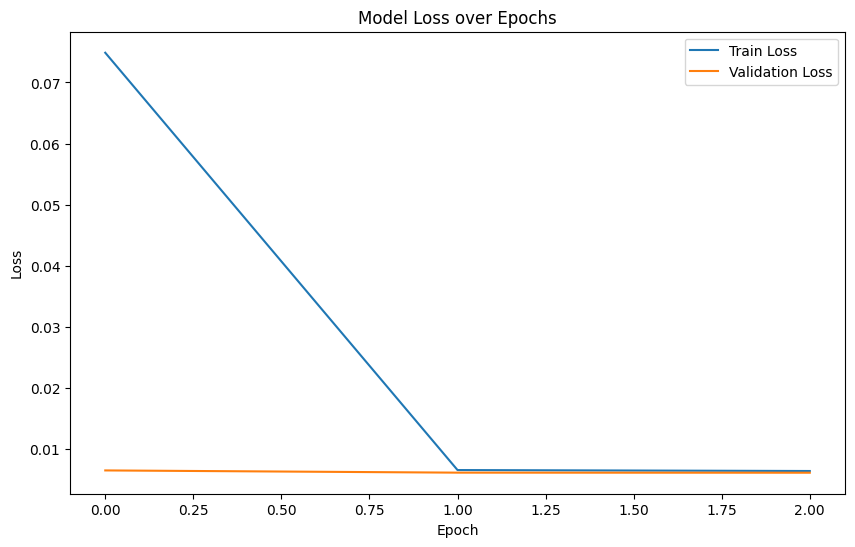

In [6]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [9]:
# Evaluate the model
y_pred = model.predict(X_test)

# Calculate MAE and R2
test_r2 = r2_score(y_test.flatten(), y_pred.flatten())

print(f'Test R²: {test_r2:.4f}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 805ms/step
Test R²: 0.7874


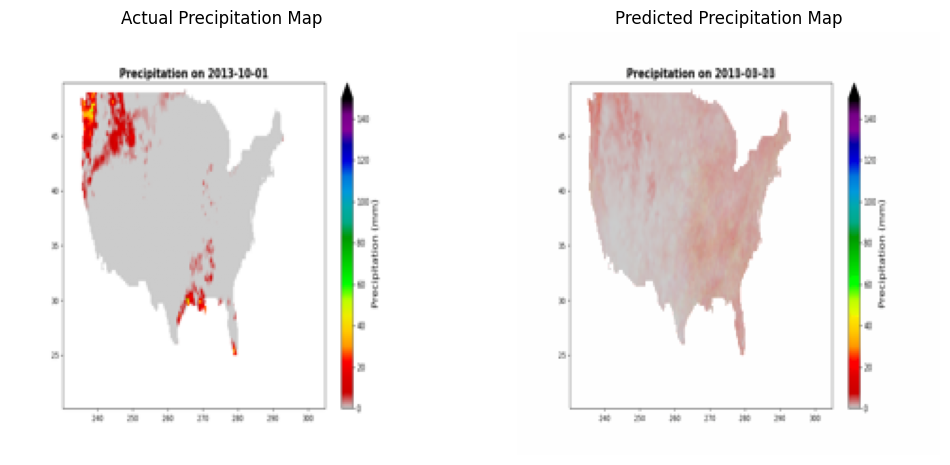

In [25]:
# Select a random date from the test set
random_idx = np.random.randint(0, X_test.shape[0])
y_pred = y_pred.reshape(-1, 224, 224, 3)

actual_map = y_test[random_idx]
predicted_map = y_pred[random_idx]

# Plot the actual and predicted heatmaps
plt.figure(figsize=(12, 6))

# Plot the actual heatmap
plt.subplot(1, 2, 1)
plt.imshow(actual_map)
plt.title('Actual Precipitation Map')
plt.axis('off')

# Plot the predicted heatmap
plt.subplot(1, 2, 2)
plt.imshow(predicted_map)
plt.title('Predicted Precipitation Map')
plt.axis('off')

plt.show()

# Improving Performance

1. Train for longer
2. Hyperparameter Tuning
3. More layers
4. Early Stopping